# Model Performance


## Prerequisites
Install python packages

In [23]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn segmentationmetrics requests

## Import required python packages

In [24]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import pydicom
import pydicom_seg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import segmentationmetrics as sm
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
import seaborn as sns
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline

# Download the segmentation results from zenodo

In [25]:
qa_dir = Path("qa-results")

In [26]:
def download_inference(
    extract_dir="qa-results", record="13244892", filename="kidney-ct.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [27]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

In [34]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    if label in result.available_segments:
        image = result.segment_image(label)
    else:
        # create an empty image
        tmp_img = result.segment_image(list(result.available_segments)[0])
        tmp_arr = sitk.GetArrayFromImage(tmp_img)
        image = sitk.GetImageFromArray(np.zeros_like(tmp_arr))
        image.CopyInformation(tmp_img)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    if label == 1:
        img = sitk.Cast(img >= label, sitk.sitkUInt8)
    else:
        img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(
    ai_seg_file, qa_seg_file, fname, label_value=1, version="aimiv2", label_suffix=""
):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
            m._surface_dist, 7
        ),
        "SeriesUID": fname,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics

In [35]:
# Load the CSV file
df = pd.read_csv(Path("qa-results/qa-results.csv"))
qa_df = df[df.Validation]

# Paths for aimiv1, aimiv2, and qa
ai_path = Path("qa-results/ai-segmentations-dcm")
qa_path = Path("qa-results/qa-segmentations-dcm")

# Initialize lists for metrics
metrics = []

# Iterate over all QA cases
for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    ai_file = ai_path / row.AISegmentation
    if not pd.isna(row.CorrectedSegmentation):
        qa_file = qa_path / row.CorrectedSegmentation
    else:
        # reviewer had no corrections, use AI segmentation as QA
        qa_file = ai_file

    assert ai_file.exists(), f"AI segmentation not found for {row.AISegmentation}"
    assert qa_file.exists(), f"QA segmentation not found for {row.QASegmentation}"

    version = "aimiv1" if row.AimiProjectYear == 2023 else "aimiv2"
    metrics.append(
        calc_metrics_for_label(
            ai_file, qa_file, row.SeriesInstanceUID, version=version, label_value=1
        )
    )
    metrics.append(
        calc_metrics_for_label(
            ai_file, qa_file, row.SeriesInstanceUID, version=version, label_value=2
        )
    )
    metrics.append(
        calc_metrics_for_label(
            ai_file, qa_file, row.SeriesInstanceUID, version=version, label_value=3
        )
    )

metrics_df = pd.DataFrame(metrics)

# Replace infinite values with NaN and drop NaN values
metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan).dropna()

100%|██████████| 85/85 [02:31<00:00,  1.78s/it]


In [42]:
# add label names
ds = pydicom.dcmread(ai_path / df.AISegmentation.iloc[0])
result = pydicom_seg.SegmentReader().read(ds)
label_names = {
    k: v["SegmentDescription"].value for k, v in result.segment_infos.items()
}

# update metrics_df with label names column
metrics_df["label_name"] = metrics_df["label"].map(label_names)

In [44]:
aggregated_df = (
    metrics_df.groupby(["label_name", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "mean_surface_distance_tol_7": ["mean", "std"],
        }
    )
    .round(2)
)

aggregated_df

dice       hausdorff_distance_95         \
                    mean   std                  mean    std   
label_name version                                            
Cyst       aimiv1   0.91  0.23                  7.36  21.80   
           aimiv2   1.00  0.00                  0.00   0.00   
Kidney     aimiv1   0.97  0.11                  8.08  29.10   
           aimiv2   1.00  0.00                  0.00   0.00   
Tumor      aimiv1   0.95  0.19                  4.52  18.31   
           aimiv2   1.00  0.00                  0.00   0.00   

                   mean_surface_distance       mean_surface_distance_tol_7  \
                                    mean   std                        mean   
label_name version                                                           
Cyst       aimiv1                   1.57  4.76                        0.94   
           aimiv2                   0.00  0.00                        1.00   
Kidney     aimiv1                   1.22  4.44                        0.97   
           aimiv2                   0.00  0.01                        1.00   
Tumor      aimiv1                   1.38  7.13                        0.95   
           aimiv2                   0.15  0.38                        1.00   

                          
                     std  
label_name version        
Cyst       aimiv1   0.17  
           aimiv2   0.00  
Kidney     aimiv1   0.09  
           aimiv2   0.00  
Tumor      aimiv1   0.18  
           aimiv2   0.00

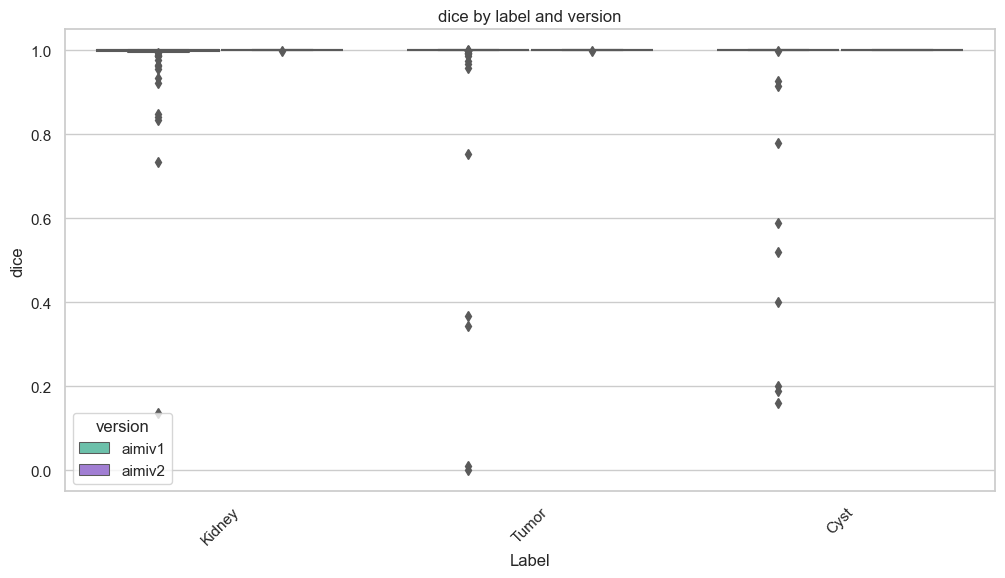

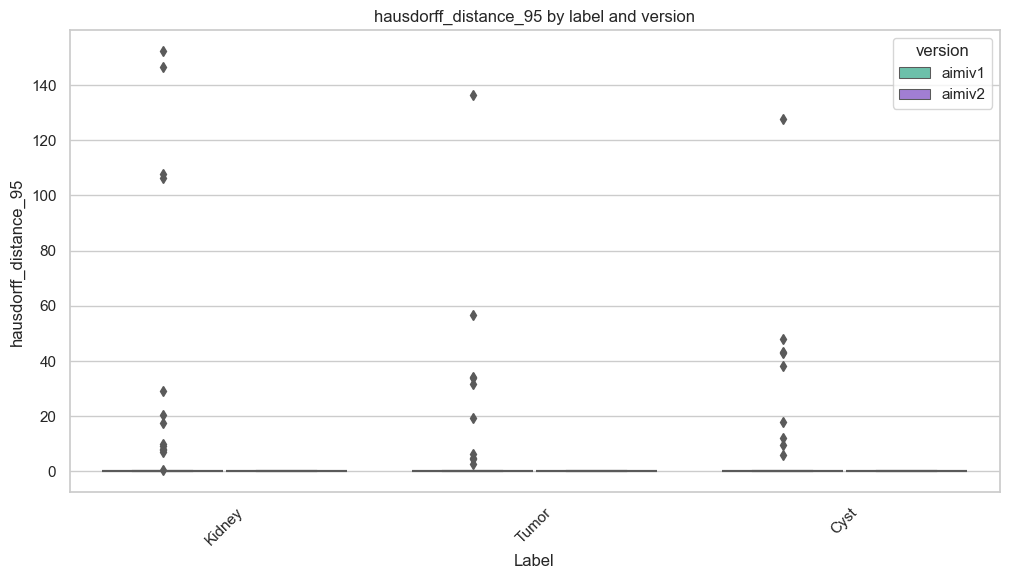

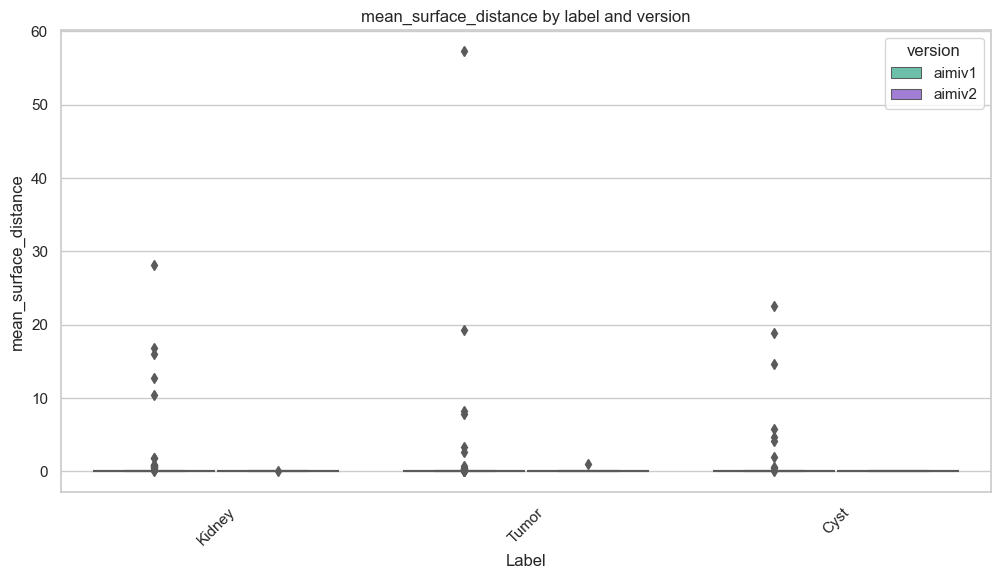

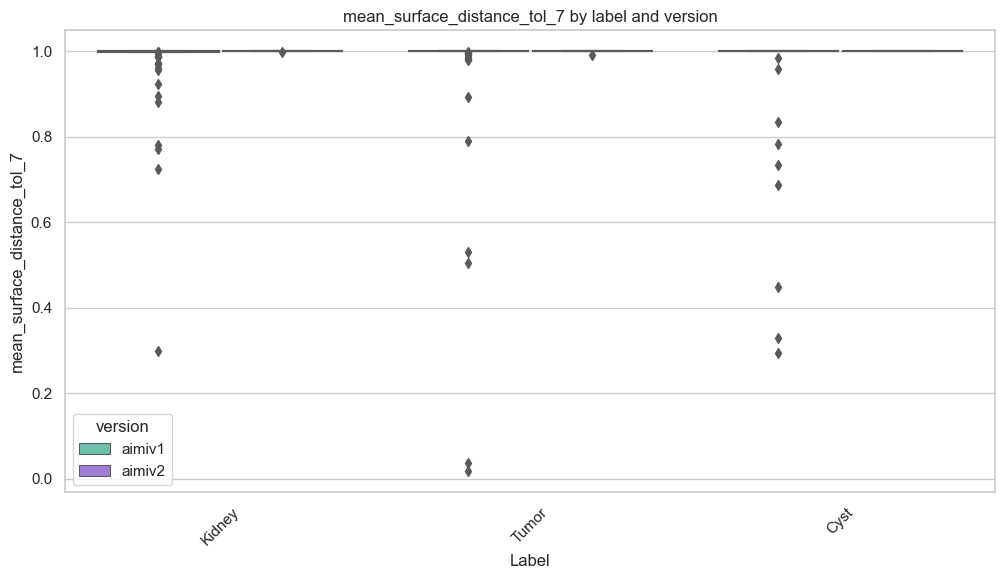

In [47]:
# create seaborn categorical boxplot for each metric, by label and version
for metric in [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "mean_surface_distance_tol_7",
]:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        x="label_name",
        y=metric,
        hue="version",
        data=metrics_df,
        palette=revewer_cmap,
        ax=ax,
    )
    ax.set_title(f"{metric} by label and version")
    ax.set_ylabel(metric)
    ax.set_xlabel("Label")
    plt.xticks(rotation=45)
    plt.show()